In [1]:
import yfinance as yf
import pandas as pd

In [2]:
sp500= yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime(sp500.index)

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-26 00:00:00-04:00,5639.660156,5651.620117,5602.339844,5616.839844,2938570000,0.0,0.0
2024-08-27 00:00:00-04:00,5602.890137,5631.180176,5593.479980,5625.799805,2798990000,0.0,0.0
2024-08-28 00:00:00-04:00,5624.509766,5627.029785,5560.950195,5592.180176,3053450000,0.0,0.0


<Axes: xlabel='Date'>

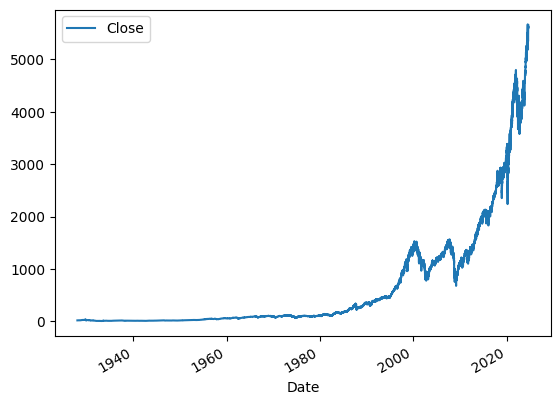

In [5]:
sp500.plot.line(y="Close", use_index=True)

In [6]:
if 'Dividends' in sp500.columns:
    del sp500['Dividends']
if 'Stock Splits' in sp500.columns:
    del sp500['Stock Splits']

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
#what we want to predict
#making a row that compares tomorrow to today

In [9]:
#remove all data before 1990
sp500 = sp500.loc["1990-01-01":].copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier

#n_estimators are the number of indiv descision trees. More = more accuracy
#min samples split protect against overfit
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
#last 100 rows are in the test set
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
RandomForestClassifier(min_samples_split=100,random_state=1)

RandomForestClassifier(min_samples_split=100, random_state=1)

In [12]:
#accuracy metric
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [13]:
import pandas as pd
#changing numpy array to panda
preds = pd.Series(preds, index=test.index)

In [14]:
precision_score(test["Target"],preds)

np.float64(0.5882352941176471)

In [15]:
combined = pd.concat([test["Target"],preds], axis=1)

<Axes: xlabel='Date'>

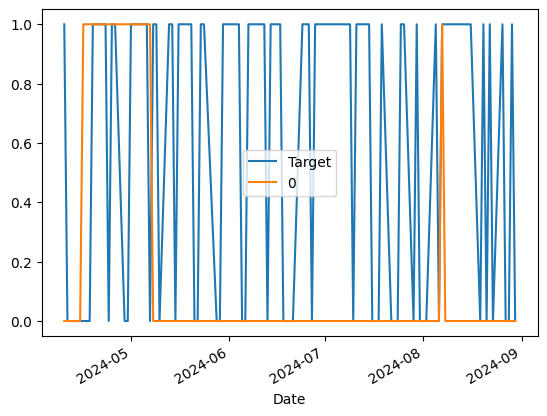

In [16]:
combined.plot()

In [17]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
        

In [18]:
def backtest(data, model, predictors, start=2500, step=250):
    #first 10 years of data, predict year elevem
    #first 11 years of data, predict year twelve
    #etc...
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [19]:
predictions = backtest(sp500, model, predictors)

In [20]:
predictions["Predictions"].value_counts()

Predictions
0    3637
1    2596
Name: count, dtype: int64

In [21]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5288906009244992)

In [22]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.535537
0    0.464463
Name: count, dtype: float64

In [23]:
#adding more predictors
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]
    

In [24]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26 00:00:00-04:00,5639.660156,5651.620117,5602.339844,5616.839844,2938570000,5625.799805,1,0.998421,1.0,1.001574,2.0,1.027271,38.0,1.134282,145.0,1.299415,526.0
2024-08-27 00:00:00-04:00,5602.890137,5631.180176,5593.479980,5625.799805,2798990000,5592.180176,0,1.000797,1.0,1.002147,3.0,1.027819,38.0,1.135057,145.0,1.300835,527.0
2024-08-28 00:00:00-04:00,5624.509766,5627.029785,5560.950195,5592.180176,3053450000,5591.959961,0,0.997003,1.0,0.997177,2.0,1.020717,37.0,1.127294,144.0,1.292414,527.0


In [25]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1) 

In [26]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] #returns probability of stock prices going up or down rather than 0 or 1
    preds[preds >= .6] = 1 #raise confidence to considert going up
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [27]:
predictions = backtest(sp500, model, new_predictors)

In [28]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5434995112414467)